# Notebook associated with the manuscript on FAIR-BioRS

## Import required packages and set high-level constants

In [1]:
import collections
import math
import os
import re
import textwrap
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from github import Github
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [2]:
COLOR_1 = "#2563EB"
COLOR_2 = "#ffd166"
COLOR_3 = "#06d6a0"
COLOR_4 = "#118ab2"
COLOR_5 = "#ef476f"
COLOR_6 = "#fb5607"
color_palette = [COLOR_1, COLOR_2, COLOR_3, COLOR_4, COLOR_5, COLOR_6]

%matplotlib inline
pd.set_option("display.max_colwidth", None)

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

current_folder = os.getcwd()

## General functions

In [3]:
def create_folder_if_not_exist(folder_path):
    """
    Create a folder at the path specified by folder_path
    if such a folder does not exist

    Args:
        folder_path: full path of the folder to create

    Returns:
        folder_path: full path of the folder created

    """
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    return folder_path


def save_image(fig, folder_path, plot_name, output_format):
    """
    Save a matplotlib fig to png image file

    Args:
        fig: matplotlib fig object
        folder_path: full path of the folder where image will be created
        plot_name: name of the image file to be created
        output_format: format of the image file to be created
                        ('png' or 'svg' typically)

    Returns:
        'Saved successfully'

    """
    folder_path = create_folder_if_not_exist(folder_path)
    file_name = plot_name + "." + output_format
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, bbox_inches="tight")
    return "Saved successfully"


def frenquency_suggestions(df_sub):
    """
    Counts how many time an item is included in dataframe column

    Args:
        df_sub: dataframe of interest

    Returns:
        frequency: dictionary where keys are unique items from the dataframe
                    column and the values are their respective frequencies

    """
    list_suggestions = list(df_sub.values)
    list_suggestions_cleaned = []
    for item in list_suggestions:
        item = item.split(";")
        list_suggestions_cleaned.extend(item)
    list_suggestions_cleaned = [x.strip() for x in list_suggestions_cleaned]
    frequency_all = dict(collections.Counter(list_suggestions_cleaned))
    frequency = dict(
        sorted(frequency_all.items(), key=lambda item: item[1], reverse=True)
    )
    return frequency


def generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
):
    """
    Generate bar plot of interest

    Args:
        x: x axis list for the plot
        y: y axis value for the plot
        fig_width: width of the figure (in inch)
        fig_height: height of the figure (in inch)
        bar_width: width of the bars (in inch)
        delta_y: offset of the bar labels w.r.t. the top of the corresponding
                 bar
        x_label: x labels of the figure
        title: Title of the figure

    Returns:
        fig: Matplotlib top level container for all the plot elements

    """
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    bars = ax.bar(x, y, bar_width, color=color_palette[0])
    for bar in bars:
        yval = bar.get_height()
        xval = bar.get_x()
        w = bar.get_width()
        ax.text(
            xval + w / 2,
            yval + delta_y,
            round(yval, 1),
            horizontalalignment="center",
        )
    if max_width_x_tick_labels:
        ax.set_xticklabels(
            textwrap.fill(label_x, max_width_x_tick_labels) for label_x in x
        )
    else:
        ax.set_xticks(x)
    ax.set_yticks(range(0, max(y) + 1, y_ticks_increment))
    ax.grid(axis="y", color="#EEEEEE")
    ax.set_axisbelow(True)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel(x_label, labelpad=15, color="#333333")
    plt.ylabel(y_label, fontsize=18)
    plt.title(
        title,
        color="#333333",
        fontsize=20,
        y=1.05,
    )
    plt.xticks(rotation=90, ha="center")
    fig.tight_layout()
    return fig

## Number of biomedical related repositories on GitHub

In [4]:
# This block can be skipped as results are already saved in the input folder
# Skip if running on Binder

GITHUB_ACCESS_TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")
g = Github(GITHUB_ACCESS_TOKEN)
print("Success: GitHub Access Token loaded")


def search_github_repo_created_month(keywords, created_month):
    """
    Get number of repositories on GitHub with "biomedical" included in the
    name, readme, or description created in a given month of a year.
    We do month-wise search since the GitHub API has a result rate limit of 1000
    assuming no single month has more than 1000 results

    Args:
        keywords: keyword to search on GitHub
        created_month: month of interest for the search
        fig_width: width of the figure (in inch)
        fig_height: height of the figure (in inch)
        bar_width: width of the bars (in inch)
        delta_y: offset of the bar labels w.r.t. the top of the corresponding
                 bar
        x_label: x labels of the figure
        title: Title of the figure

    Returns:
        result: GitHub query result

    """
    created_month_query = " created:" + created_month
    query = (
        keywords + " in:name" + " in:readme" + " in:description" + created_month_query
    )
    result = g.search_repositories(query)
    return result


keywords = "biomedical"
start_year = 2010
end_year = 2021
year_list = [str(x) for x in range(start_year, end_year + 1)]
month_list = ["%.2d" % x for x in range(1, 13)]
df = pd.DataFrame(columns=["year", "month", "count"])
search_count = 0
search_limit = 30
for year in year_list:
    for month in month_list:
        created_month = year + "-" + month
        result = search_github_repo_created_month(keywords, created_month)
        df.loc[len(df.index)] = [year, month, result.totalCount]
        search_count += 1
        if search_count == search_limit:
            time.sleep(65)
            search_count = 0
print(
    "Success: Month-wise number of repositories created on GitHub between "
    + str(start_year)
    + " and "
    + str(end_year)
    + " with keyword biomedical pulled and saved in a dataframe"
)

# get year wise results
df_yearwise = pd.DataFrame(columns=["year", "count"])
for year in year_list:
    df_sub = df[df["year"] == year]
    total = df_sub["count"].sum()
    df_yearwise.loc[len(df_yearwise.index)] = [year, total]
df_yearwise.to_csv("github_biomedical_repo_count_yearwise.csv")
print(
    "Success: Year-wise number of repositories created on GitHub between "
    + str(start_year)
    + " and "
    + str(end_year)
    + " with keyword biomedical calculated saved in a dataframe and in a csv file"
)

Success: GitHub Access Token loaded
Success: Month-wise number of repositories created on GitHub between 2010 and 2021 with keyword biomedical pulled and saved in a dataframe
Success: Year-wise number of repositories created on GitHub between 2010 and 2021 with keyword biomedical calculated saved in a dataframe and in a csv file


'Saved successfully'

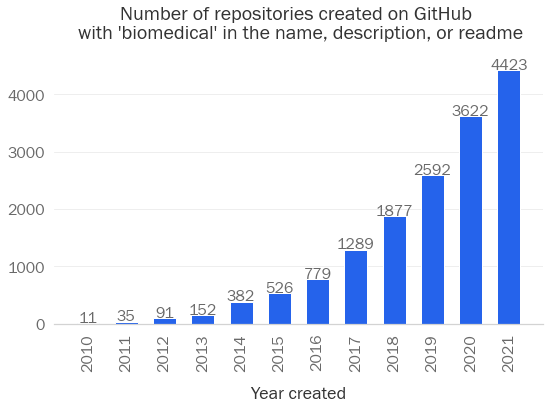

In [7]:
# visualize year-wise results
github_input_file = "https://raw.githubusercontent.com/fairdataihub/FAIR-BioRS-code/main/input/github_biomedical_repo_count_yearwise.csv"
df = pd.read_csv(
    github_input_file
)  # or use df = df_yearwise if not working from pre-saved results
x = df["year"]
y = df["count"]
fig_width = 8
fig_height = 6
bar_width = 0.6
delta_y = 20
x_label = "Year created"
y_label = ""
max_width_x_tick_labels = ""
y_ticks_increment = 1000
title = "Number of repositories created on GitHub \n with 'biomedical' in the name, description, or readme"
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "github-biomedical-repo-count-yearwise"
save_image(fig, "output", plot_name, "png")

## Review analysis

In [5]:
# Load review data
data_file_location = "https://raw.githubusercontent.com/fairdataihub/FAIR-BioRS-data/main/docs/resourcesReviewKeywords.csv"
df = pd.read_table(data_file_location, encoding="utf-8", sep=",")
print("Data loaded successfuly")
df.head()

Data loaded successfuly


,count,reviewCategory,doiOrLink,firstAuthor,year,title,foundThrough,mentionsFAIR,isRelevant,comments,...,dataFileHelp,metadataFilesSuggestion,metadataHelp,licenseSuggestion,licenseHelp,repositorySuggestion,repositoryHelp,registerySuggestion,registeryHelp,FAIRhelp
0,1,1,https://doi.org/10.15497/RDA00065,Chue Hong,2021.0,FAIR Principles for Research Software (FAIR4RS Principles),NaN,yes,yes,NaN,...,NaN,CodeMeta,NaN,Open source licenses,https://spdx.dev/,NaN,NaN,NaN,NaN,NaN
1,2,1,https://doi.org/10.1016/j.patter.2021.100222,Katz,2020.0,Taking a fresh look at FAIR for research software,NaN,yes,yes,Summarizes findings of the FAIR4RS working group 1 but do not cover actionable items much,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,https://doi.org/10.3233/DS-190026,Lampretch,2020.0,Towards FAIR principles for research software,NaN,yes,yes,NaN,...,NaN,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,NaN,Open source licenses; Permissive licenses,https://spdx.dev/,Zenodo; Software Heritage; CRAN; PyPI; Conda; Figshare; Bioconductor,NaN,Zenodo; Software Heritage; CRAN; PyPI; Figshare; BioConductor; bio.tools; Conda; BioContainers,NaN,NaN
3,4,2,https://doi.org/10.5281/zenodo.4095092,Gruenpeter,2020.0,M2.15 Assessment report on 'FAIRness of software,https://doi.org/10.15497/RDA00065,yes,yes,NaN,...,NaN,CodeMeta,NaN,NaN,https://spdx.dev/; https://reuse.software/,Zenodo; HAL; Software Heritage; CRAN; PyPI,NaN,Zenodo; HAL; Software Heritage; CRAN; PyPI,NaN,NaN
4,5,2,https://op.europa.eu/s/vkhr,European Commission,2018.0,Turning FAIR into reality,https://doi.org/10.15497/RDA00065,yes,no,Does not address research software specifically,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Number of studies in the review
df_sub = df[df["isRelevant"] == "yes"]
total_studies = len(df_sub)
print(str(total_studies) + " relevant studies were included in the review")

27 relevant studies were included in the review


### Standards

In [27]:
# Number of studies
df_sub = df[["doiOrLink", "title", "standardsSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the standards to follow when developing a research software"
)

From the reviewed studies, 0 made a suggestion about the standards to follow when developing a research software


In [28]:
df_sub = df[["doiOrLink", "title", "standardsHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with standards"
)

From the reviewed studies, 1 made a suggestion about resources to help with standards


In [29]:
display(df_sub)

,doiOrLink,title,standardsHelp
0,https://doi.org/10.15497/RDA00065,FAIR Principles for Research Software (FAIR4RS Principles),https://fairsharing.org/standards/.


### Best practices

In [30]:
# Number of studies
df_sub = df[["doiOrLink", "title", "bestPracticeSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the best practices to follow when developing a research software"
)

From the reviewed studies, 15 made a suggestion about the best practices to follow when developing a research software


In [31]:
# Frequency of suggestions
list_suggestions = df_sub["bestPracticeSuggestion"]
list_suggestions_cleaned = []
for item in list_suggestions:
    item = item.split(";")
    item = [re.sub("[\(\[].*?[\)\]]", "", x) for x in item]
    item = [x.strip() for x in item]
    list_suggestions_cleaned.extend(item)
list_suggestions_unique = list(set(list_suggestions_cleaned))
frequency = {}
for item in list_suggestions_unique:
    df_sub2 = df_sub[df_sub["bestPracticeSuggestion"].str.contains(item)]
    frequency[item] = len(df_sub2)
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
print(frequency)

{'Develop with a version control system': 12, 'Use container technologies': 6, 'Have code level documentation': 5, 'Provide tests': 3, 'Record dependencies': 2, 'Make code modular': 2, 'Include sample data': 1}


'Saved successfully'

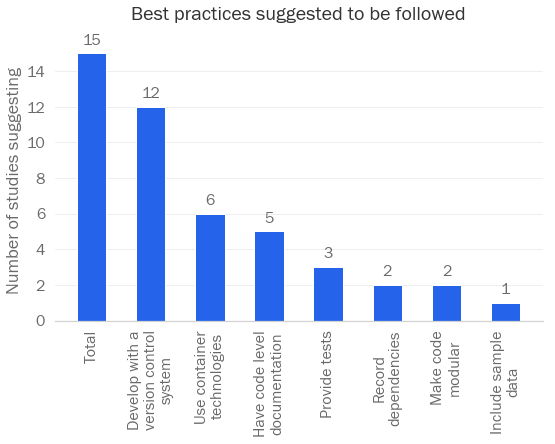

In [32]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 8
fig_height = 6.5
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Best practices suggested to be followed"
max_width_x_tick_labels = 16
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "best-practices-suggested"
save_image(fig, "output", plot_name, "svg")

In [33]:
# Number of studies
df_sub = df[["doiOrLink", "title", "bestPracticeHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with best practices"
)

From the reviewed studies, 3 made a suggestion about resources to help with best practices


### Best practices for documentation

In [34]:
df_sub = df[["doiOrLink", "title", "documentationSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about documenting a research software"
)

From the reviewed studies, 6 made a suggestion about documenting a research software


In [58]:
df_sub = df[["doiOrLink", "title", "documentationHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with documenting a research software"
)

From the reviewed studies, 6 made a suggestion about resources to help with documenting a research software


### Files suggested to be shared

In [36]:
# Number of studies
df_sub = df[["doiOrLink", "title", "dataFileSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the files to be shared for a research software"
)

From the reviewed studies, 6 made a suggestion about the files to be shared for a research software


In [37]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["dataFileSuggestion"])
print(frequency)

{'Source code': 6, 'Executable': 2, 'Input data': 1, 'Result data': 1}


'Saved successfully'

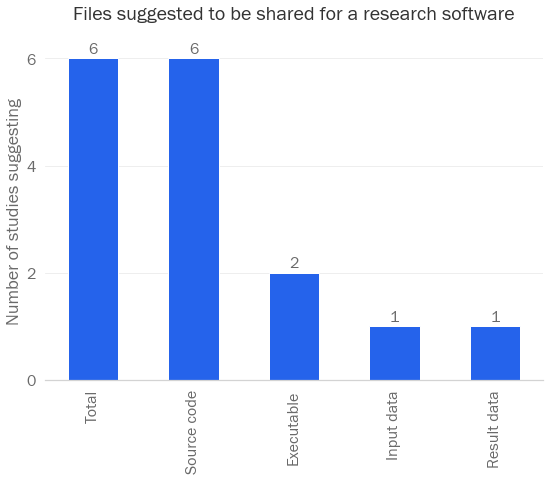

In [38]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 8
fig_height = 7
bar_width = 0.5
delta_y = 0.1
x_label = ""
y_label = "Number of studies suggesting"
title = "Files suggested to be shared for a research software"
max_width_x_tick_labels = 16
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "files-suggested"
save_image(fig, "output", plot_name, "svg")

### Metadata files suggested to be included

In [55]:
# Number of studies
df_sub = df[["doiOrLink", "title", "metadataFilesSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the metadata files and ontologies to be used for a research software"
)
# display(df_sub)

From the reviewed studies, 16 made a suggestion about the metadata files and ontologies to be used for a research software


In [56]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["metadataFilesSuggestion"])
print(frequency)

{'CodeMeta': 12, 'Citation File Format': 6, 'EDAM': 3, 'Bioschemas': 2, 'A CITATION file': 2, 'biotoolsSchema': 1, 'R packages DESCRIPTION file': 1, 'PEP 566 Metadata for Python Packages': 1, 'Software Ontology': 1, 'PROV-O': 1, 'RDA Research Schemas': 1}


'Saved successfully'

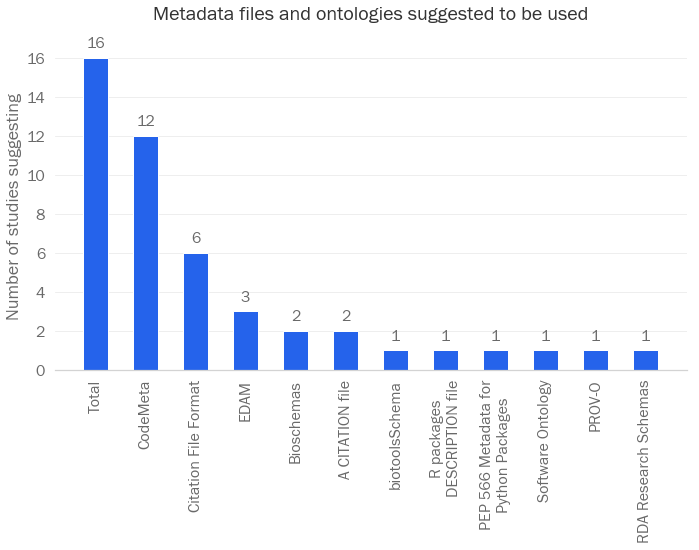

In [57]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 8
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Metadata files and ontologies suggested to be used"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "metadata-files-suggested"
save_image(fig, "output", plot_name, "svg")

### License suggested to be used

In [52]:
# Number of studies
df_sub = df[["doiOrLink", "title", "licenseSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the licenses to be used for sharing a research software"
)

From the reviewed studies, 14 made a suggestion about the licenses to be used for sharing a research software


In [53]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["licenseSuggestion"])
print(frequency)

{'Open source licenses': 8, 'OSI-approved licenses': 3, 'Apache 2.0': 3, 'MIT': 3, 'Permissive licenses': 2, 'Licenses from the SPDX referential catalog': 1, 'FSF-approved licenses': 1, 'BSD': 1}


'Saved successfully'

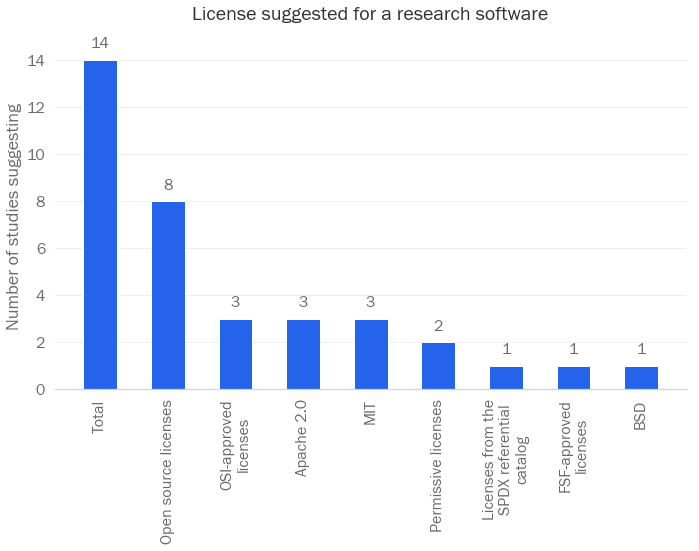

In [54]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 8
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "License suggested for a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "license-suggested"
save_image(fig, "output", plot_name, "svg")

In [60]:
# Number of studies
df_sub = df[["doiOrLink", "title", "licenseHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with selecting a license for research software"
)

From the reviewed studies, 14 made a suggestion about resources to help with selecting a license for research software


### Repositories suggested to be used

In [61]:
# Number of studies
df_sub = df[["doiOrLink", "title", "repositorySuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about a repository to use for sharing research software"
)

From the reviewed studies, 18 made a suggestion about a repository to use for sharing research software


In [62]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["repositorySuggestion"])
print(frequency)

{'Zenodo': 17, 'Figshare': 10, 'Software Heritage': 9, 'CRAN': 5, 'PyPI': 3, 'HAL': 3, 'Conda': 2, 'Bioconductor': 2, 'ModelDB': 1, 'Mendeley Data': 1, 'Dockstore': 1, 'NanoHub': 1, 'Dataverse': 1}


'Saved successfully'

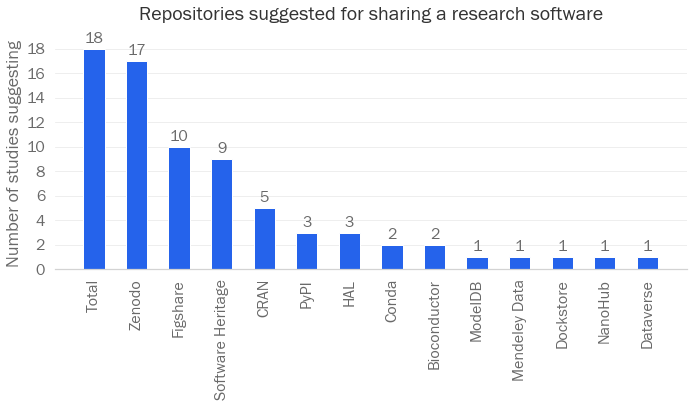

In [63]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 6
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Repositories suggested for sharing a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "repositories-suggested"
save_image(fig, "output", plot_name, "svg")

### Registeries suggested to be used

In [65]:
# Number of studies
df_sub = df[["doiOrLink", "title", "registerySuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the registeries to use for a research software"
)

From the reviewed studies, 5 made a suggestion about the registeries to use for a research software


In [66]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["registerySuggestion"])
print(frequency)

{'Zenodo': 4, 'bio.tools': 3, 'Software Heritage': 2, 'CRAN': 2, 'PyPI': 2, 'Figshare': 1, 'BioConductor': 1, 'Conda': 1, 'BioContainers': 1, 'HAL': 1, 'biojs.io': 1, 'Omic Tools': 1, 'DataCite': 1, 'BioCatalogue': 1, 'Research Software Directory': 1, 'rOpenSci Project': 1}


'Saved successfully'

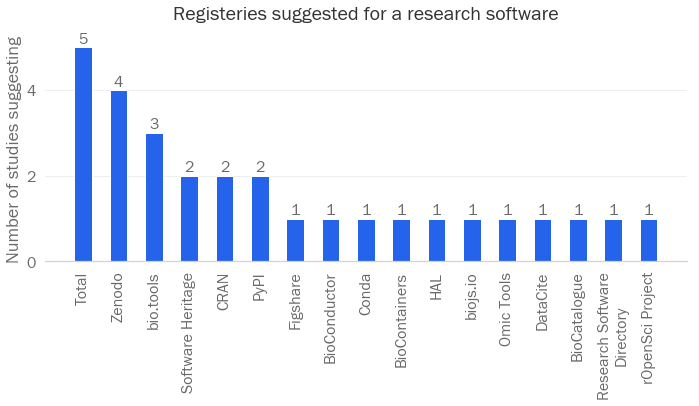

In [67]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 6
bar_width = 0.5
delta_y = 0.1
x_label = ""
y_label = "Number of studies suggesting"
title = "Registeries suggested for a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "registeries-suggested"
save_image(fig, "output", plot_name, "svg")